# Bank Telemarketing Project - Preprocessing and Modeling
***

## Contents<a id='Table of Contents'></a>

- [Imports](#Imports)
- [Load The Bank Data](#Load_The_Bank_Data)
- [Preprocessing](#Preprocessing)
  - [Log Transform Balance Data](#Log_Transform_Balance_Data)
  - [Delete Repetitive Features](#Delete_Repetitive_Features)
  - [Transform Categorical Features](#Transform_Categorical_Features)
  - [Replace 'pdays' Negative Values](#Replace_pdays_Negative_Values)

- [Train/Test Split](#Train_Test_Split)
- [Logistic Regression Model](#Logistic_Regression_Model)
  - [Scale The Data](<#Scale_The_Data)
  - [With All Features](#With_All_Featuresa)
  - [Feature Selection](#Feature_Selection)
  - [With Five Features](#With_Five_Featuresa)
  - [With Ten Features](#With_Ten_Featuresa)

- [Random Forest Model](#Random_Forest_Model)
  - [With All Features](#With_All_Featuresa_RF)
  - [Feature Selection](#Feature_Selection_RF)
  - [With Five Features](#With_Five_Featuresa_RF)
  - [With Ten Features](#With_Ten_Featuresa_RF)

- [Gradient Boosting Model](#Gradient_Boosting_Model)
  - [With All Features](#With_All_Featuresa_GB)
  - [Feature Selection](#Feature_Selection_GB)
  - [With Five Features](#With_Five_Featuresa_GB)
  - [With Ten Features](#With_Ten_Featuresa_GB)

- [ROC Curve](#ROC_Curve)
- [Threshold For Profitability](#Threshold_For_Profitability)
  - [Obtain Revenue Per Subscription](#Obtain_Revenue_Per_Subscription)
  - [Calculate Cost Per Subscription](#Calculate_Cost_Per_Subscription)
  - [Calculate Profitability Vs. Threshold](#Calculate_Profitability_Threshold)

- [Test Data](#Test_Data)
  - [Calcuate ROC AUC Score](#Calcuate_ROC_AUC_Score)
  - [Classification Report](#Classification_Report)
  - [Confusion Matrix](#Confusion_Matrix)

- [Modeling Scenarios](#Modeling_Scenarios)
  - [GB Model](#GB_Model)
  - [Scenario 1](#Scenario_1)
  - [Scenario 2](#Scenario_2)
  - [Scenario 3](#Scenario_3)

- [Plot and Summary](#Plot_and_Summary)
- [Future Work](#Future_Work)



### Imports<a id='Imports'></a>
***

In [44]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve,roc_auc_score

import warnings
warnings.filterwarnings('ignore')

### Load The Bank Data<a id='Load_The_Bank_Data'></a>
***

In [6]:
bank_cleaned2 = pd.read_csv('../data/bank_cleaned2.csv', index_col=0)

In [7]:
bank_cleaned2.head()

,age,job,marital,education,credits,balance,housing,loan,contact_type,day,...,campaign,pdays,previous,poutcome,subscription,month_num,balance_group,campaign_contact_number,pdays_group,age_group
0,95,retired,married,secondary,no,0,no,no,telephone,1,...,1,-1,0,2,0,10,no_balance,NaN,NaN,>60
1,95,retired,divorced,primary,no,2282,no,no,telephone,21,...,17,-1,0,2,1,4,high_balance,>6,NaN,>60
2,94,retired,divorced,secondary,no,1234,no,no,cellular,3,...,1,-1,0,2,0,3,average_balance,NaN,NaN,>60
3,93,retired,married,unknown,no,775,no,no,cellular,4,...,2,13,9,1,1,8,average_balance,1,1-4months,>60
4,93,retired,married,unknown,no,775,no,no,cellular,22,...,2,177,7,1,1,7,average_balance,1,4-7months,>60


In [8]:
bank_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45210 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      45210 non-null  int64 
 1   job                      45210 non-null  object
 2   marital                  45210 non-null  object
 3   education                45210 non-null  object
 4   credits                  45210 non-null  object
 5   balance                  45210 non-null  int64 
 6   housing                  45210 non-null  object
 7   loan                     45210 non-null  object
 8   contact_type             45210 non-null  object
 9   day                      45210 non-null  int64 
 10  duration                 45210 non-null  int64 
 11  campaign                 45210 non-null  int64 
 12  pdays                    45210 non-null  int64 
 13  previous                 45210 non-null  int64 
 14  poutcome                 45210 non-nul

### Preprocessing<a id='Preprocessing'></a>

#### Log Transform Balance Data<a id='Log_Transform_Balance_Data'></a>
Since balance data is very skewed, I decided to do the log transformation to see if the linearity can be improved.

In [9]:
#Use the data to prepare for the bins
bank_cleaned2['balance'].describe()

count     45210.000000
mean       1362.290179
std        3044.797065
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [10]:
#Put the balance data into five bins and calcuate counts for each bin
bins = [-1000000000, 0, 1358, 4400, 102127]
category = ['no_balance', 'low_balance', 'average_balance','high_balance']
bank_cleaned2['balance_group'] = pd.cut(bank_cleaned2['balance'], bins, labels = category)
bank_cleaned2['balance_group'].value_counts()


low_balance        26165
average_balance     8309
no_balance          7280
high_balance        3456
Name: balance_group, dtype: int64

In [11]:
#Calculate the subscription rate within each group

b_subscription_rate = pd.crosstab(bank_cleaned2.balance_group,bank_cleaned2.subscription).apply(lambda row: row/row.sum(), axis=1)
b_subscription_rate.columns = ['No', 'Yes']
b_subscription_rate


,No,Yes
balance_group,,
no_balance,0.931044,0.068956
low_balance,0.888897,0.111103
average_balance,0.839210,0.160790
high_balance,0.842593,0.157407


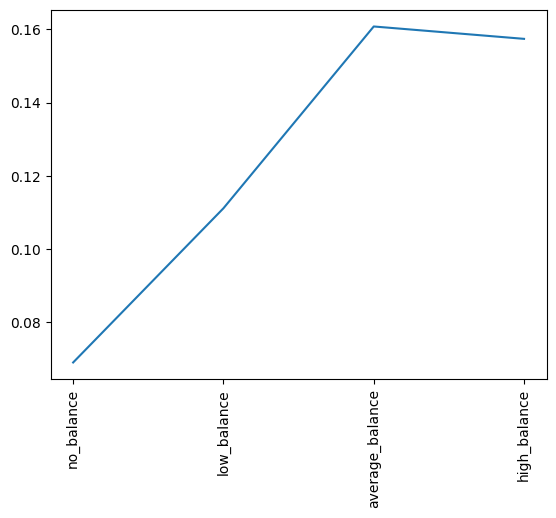

In [12]:
#plot the dataframe

plt.plot(b_subscription_rate['Yes'])
plt.xticks(rotation='vertical')

plt.show()

In [13]:
#Make log transformation on balance
def make_log_balance(num):
    if num == 0:
        return 0
    elif num < 0:
        return -np.log(abs(num))
    else:
        return np.log(num)

In [14]:
#Compare balance_log and balance
bank_cleaned2['balance_log'] = bank_cleaned2['balance'].apply(make_log_balance)
bank_balance_log= bank_cleaned2[['balance_log','balance']]
bank_balance_log.head()
#bank_cleaned2['natural_log'].value_counts()

,balance_log,balance
0,0.000000,0
1,7.732808,2282
2,7.118016,1234
3,6.652863,775
4,6.652863,775


In [15]:
bank_cleaned2['balance_log'].describe()

count    45210.000000
mean         4.877992
std          3.812037
min         -8.989569
25%          4.276666
50%          6.104793
75%          7.264030
max         11.533972
Name: balance_log, dtype: float64

In [16]:
#Put balance_log into bins
bins_log = [-100000000, 0, 4.87, 8.6, 12]
category_log = ['no_balance', 'low_balance', 'average_balance','high_balance']
bank_cleaned2['balance_group_log'] = pd.cut(bank_cleaned2['balance_log'], bins_log, labels = category_log)


In [17]:
bank_cleaned2['balance_group_log'].value_counts()

average_balance    29166
no_balance          7475
low_balance         6087
high_balance        2482
Name: balance_group_log, dtype: int64

In [18]:
#Calculate the subscription rate within each log group

log_subscription_rate = pd.crosstab(bank_cleaned2.balance_group_log,bank_cleaned2.subscription).apply(lambda row: row/row.sum(), axis=1)
log_subscription_rate.columns = ['No', 'Yes']
log_subscription_rate

,No,Yes
balance_group_log,,
no_balance,0.930569,0.069431
low_balance,0.914408,0.085592
average_balance,0.867243,0.132757
high_balance,0.848106,0.151894


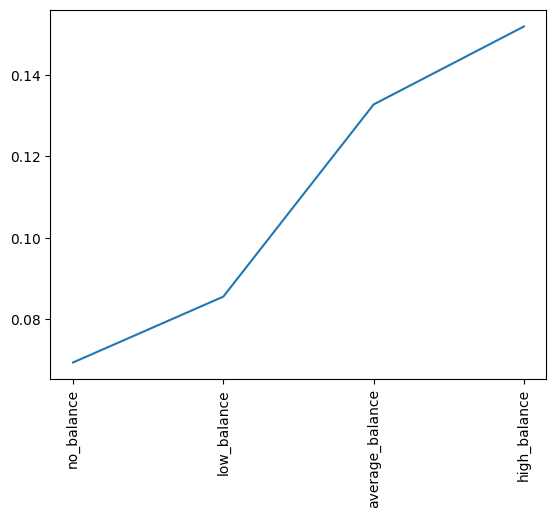

In [19]:
plt.plot(log_subscription_rate['Yes'])
plt.xticks(rotation='vertical')

plt.show()

In [20]:
#Delete the original balance data
bank_cleaned2 = bank_cleaned2.drop(columns =['balance','balance_group'])

#### Delete Repetitive Features<a id='Delete_Repetitive_Features'></a>

I dropped a few repetitive columns for better model performance. In addition, the 'Duration' column was dropped to avoid data leak issues since it was a feature we didn't know about before making phone calls.

In [22]:
bank_modeling = bank_cleaned2.drop(columns =['balance_group_log','pdays_group','age','campaign_contact_number', 'duration'])


#### Transform Categorical Features<a id='Transform_Categorical_Features'></a>

In [25]:
#Convert categorical variables into dummy variables
categorical_features = ['contact_type', 'loan', 'housing', 'credits', 'education', 'marital', 'job', 'age_group']
bank_dummies = pd.get_dummies(bank_modeling, columns = categorical_features)
print('The data have ', bank_modeling.shape[0], ' rows and ', bank_modeling.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(bank_dummies.columns)))


The data have  45210  rows and  16  columns

column names: 

day
campaign
pdays
previous
poutcome
subscription
month_num
balance_log
contact_type_cellular
contact_type_telephone
contact_type_unknown
loan_no
loan_yes
housing_no
housing_yes
credits_no
credits_yes
education_primary
education_secondary
education_tertiary
education_unknown
marital_divorced
marital_married
marital_single
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
age_group_30-40
age_group_40-50
age_group_50-60
age_group_<30
age_group_>60


In [26]:
bank_dummies.head()

,day,campaign,pdays,previous,poutcome,subscription,month_num,balance_log,contact_type_cellular,contact_type_telephone,...,job_services,job_student,job_technician,job_unemployed,job_unknown,age_group_30-40,age_group_40-50,age_group_50-60,age_group_<30,age_group_>60
0,1,1,-1,0,2,0,10,0.000000,0,1,...,0,0,0,0,0,0,0,0,0,1
1,21,17,-1,0,2,1,4,7.732808,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,1,-1,0,2,0,3,7.118016,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,13,9,1,1,8,6.652863,1,0,...,0,0,0,0,0,0,0,0,0,1
4,22,2,177,7,1,1,7,6.652863,1,0,...,0,0,0,0,0,0,0,0,0,1


#### Replace 'pdays' Negative Values<a id='Replace_pdays_Negative_Values'></a>

In [27]:
#replace 'pdays' negative outlier with a positive number

bank_dummies['pdays'].replace(-1,9999, inplace=True)
bank_dummies.head()

,day,campaign,pdays,previous,poutcome,subscription,month_num,balance_log,contact_type_cellular,contact_type_telephone,...,job_services,job_student,job_technician,job_unemployed,job_unknown,age_group_30-40,age_group_40-50,age_group_50-60,age_group_<30,age_group_>60
0,1,1,9999,0,2,0,10,0.000000,0,1,...,0,0,0,0,0,0,0,0,0,1
1,21,17,9999,0,2,1,4,7.732808,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,1,9999,0,2,0,3,7.118016,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,13,9,1,1,8,6.652863,1,0,...,0,0,0,0,0,0,0,0,0,1
4,22,2,177,7,1,1,7,6.652863,1,0,...,0,0,0,0,0,0,0,0,0,1


### Train/Test Split<a id='Train_Test_Split'></a>

In [28]:
X = bank_dummies.drop(columns = ['subscription'])
print("X: ", type(X), X.shape)

X:  <class 'pandas.core.frame.DataFrame'> (45210, 40)


In [29]:
y = bank_dummies['subscription']
print("y: ", type(y), y.shape)

y:  <class 'pandas.core.series.Series'> (45210,)


In [30]:
list(X.columns)

['day',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'month_num',
 'balance_log',
 'contact_type_cellular',
 'contact_type_telephone',
 'contact_type_unknown',
 'loan_no',
 'loan_yes',
 'housing_no',
 'housing_yes',
 'credits_no',
 'credits_yes',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'age_group_30-40',
 'age_group_40-50',
 'age_group_50-60',
 'age_group_<30',
 'age_group_>60']

In [31]:
Xlr, Xtest, ylr, ytest = train_test_split(X, y, test_size = 0.25, random_state = 2, stratify = y)
print('Training split has ', Xlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ylr))+ ')')
print('test split has ', Xtest.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ytest)) + ')')

Training split has  33907  rows
 and the corresponding labels have an equal number of values. (33907)
test split has  11303  rows
 and the corresponding labels have an equal number of values. (11303)


### Logistic Regression Model<a id='Logistic_Regression_Model'></a>


#### Scale The Data<a id='Scale_The_Data'></a>

In [35]:
#The RobustScaler removes the median and scales the data between the 1st and 3rd quartile 
from sklearn.preprocessing import RobustScaler
Xlr_scaled=RobustScaler().fit_transform(Xlr)

#### With All Features<a id='With_All_Featuresa'></a>

In [34]:
log_reg = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['C'] = [0.01, .1, 1, 10]
#Hyperparameter search using GridSearchCV
logreg_gs = GridSearchCV(log_reg, space, cv=5,scoring='roc_auc')
logreg_gs.fit(Xlr_scaled, ylr)

print(logreg_gs.best_params_, logreg_gs.best_score_)

{'C': 10, 'solver': 'liblinear'} 0.742645049507271


#### Feature Selection<a id='Feature_Selection'></a>

<AxesSubplot:title={'center':'Feature Importance'}>

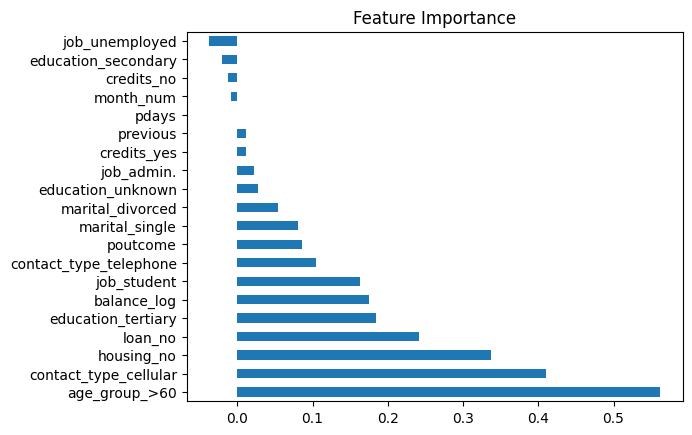

In [36]:
importance = logreg_gs.best_estimator_.coef_[0]

feat_importances = pd.Series(importance, index=Xlr.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')


In [39]:
log_feature_5 = ['education_tertiary', 'age_group_>60', 'housing_no','contact_type_cellular', 'loan_no']
log_feature_10 =  ['job_student', 'age_group_>60', 'housing_no','contact_type_cellular', 'loan_no', 'balance_log', 'contact_type_telephone', 'education_tertiary', 'poutcome', 'marital_single']


#### With Five Features<a id='With_Five_Featuresa'></a>

In [41]:
X_log_5 = Xlr[log_feature_5]
Xlr_log5_scaled= RobustScaler().fit_transform(X_log_5)
log_reg_5 = LogisticRegression()
#Hyperparameter search using GridSearchCV
logreg_gs_5 = GridSearchCV(log_reg_5, space, cv=5,scoring='roc_auc')
logreg_gs_5.fit(Xlr_log5_scaled, ylr)

print(logreg_gs_5.best_params_, logreg_gs_5.best_score_)

{'C': 0.1, 'solver': 'liblinear'} 0.6953698031057876


#### With Ten Features<a id='With_Ten_Featuresa'></a>

In [42]:
X_log_10 = Xlr[log_feature_10]
Xlr_log10_scaled=RobustScaler().fit_transform(X_log_10)
log_reg_10 = LogisticRegression()
#Hyperparameter search using GridSearchCV
logreg_gs_10 = GridSearchCV(log_reg_10, space, cv=5,scoring='roc_auc')
logreg_gs_10.fit(Xlr_log10_scaled, ylr)

print(logreg_gs_10.best_params_, logreg_gs_10.best_score_)


{'C': 0.1, 'solver': 'liblinear'} 0.7220055905123484


Logistic Regression Model with all features has better roc_auc score than with selective features. 

### Random Forest Model<a id='Random_Forest_Model'></a>

#### With All Features<a id='With_All_Featuresa_RF'></a>

In [46]:
RFModel=RandomForestClassifier(random_state=2)

param_grid = { 
    'n_estimators': [200, 500],    
    'max_depth' : [3,4,5,6]
   }
#Hyperparameter search using GridSearchCV
RFModel = GridSearchCV(RFModel, param_grid, cv= 5, scoring='roc_auc')
RFModel.fit(Xlr, ylr)
print(RFModel.best_params_, RFModel.best_score_)



{'max_depth': 6, 'n_estimators': 500} 0.7699041316672158


#### Feature Selection<a id='Feature_Selection_RF'></a>

30


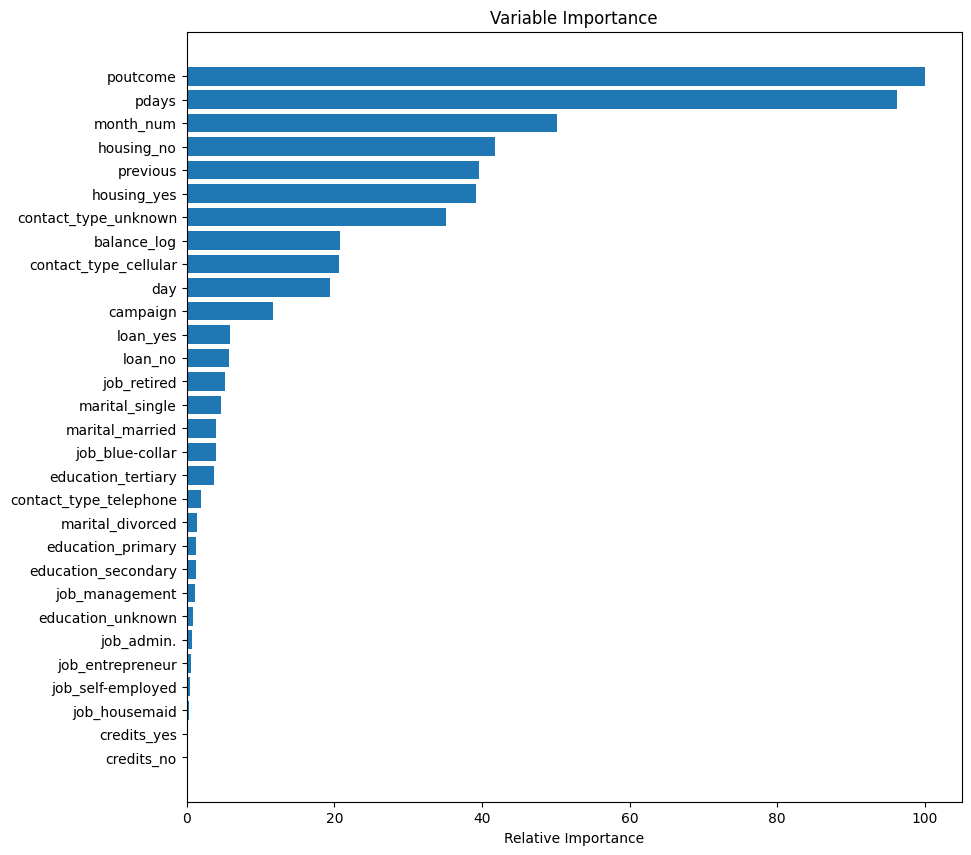

In [47]:
feature_importance = RFModel.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

'poutcome', ‘pdays’, 'month_num’, ‘housing_no’, ‘previous’ are the five most important features, according to the random forest model.  However, a majority of customers hadn’t been contacted before, so they didn't have information on the ‘poutcome’, ‘pdays’ and ‘previous.’

In [49]:
forest_feature_5 = ['month_num', 'previous', 'pdays','poutcome', 'housing_no']
forest_feature_10 =  ['contact_type_unknown', 'previous', 'pdays','poutcome', 'housing_yes', 'housing_no', 'month_num', 'day','contact_type_cellular']


#### With Five Features<a id='With_Five_Featuresa_RF'></a>

In [50]:
X_forest_5 = Xlr[forest_feature_5]
RFModel_5 = RandomForestClassifier(random_state=2)
#Hyperparameter search using GridSearchCV
RFModel_5 = GridSearchCV(RFModel_5, param_grid, cv= 5, scoring='roc_auc')
RFModel_5.fit(X_forest_5, ylr)
print(RFModel_5.best_params_, RFModel_5.best_score_)

{'max_depth': 6, 'n_estimators': 200} 0.7383292693344332


#### With Ten Features<a id='With_Ten_Featuresa_RF'></a>

In [51]:
X_forest_10 = Xlr[forest_feature_10]
RFModel_10 = RandomForestClassifier(random_state=2)
#Hyperparameter search using GridSearchCV
RFModel_10 = GridSearchCV(RFModel_10, param_grid, cv= 5, scoring='roc_auc')
RFModel_10.fit(X_forest_10, ylr)
print(RFModel_10.best_params_, RFModel_10.best_score_)

{'max_depth': 6, 'n_estimators': 500} 0.7744012633960903


Random Forest Model with Ten features has better roc_auc score than with five features and all features. 

### Gradient Boosting Model<a id='Gradient_Boosting_Model'></a>

#### With All Features<a id='With_All_Featuresa_GB'></a>

In [57]:
GBModel =GradientBoostingClassifier(random_state = 2)
parameters = {
    "n_estimators":[10,20],
    "learning_rate": [0.05, 0.1, 0.25, 0.5,0.75,1],
    "max_depth":[2,5,8],
    "max_features":["log2","sqrt"]   
    }
#Hyperparameter search using GridSearchCV
GBModel= GridSearchCV(GBModel, parameters, cv= 5, scoring='roc_auc')
GBModel.fit(Xlr, ylr)
print(GBModel.best_params_, GBModel.best_score_)


{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 20} 0.7829025583298613


#### Feature Selection<a id='Feature_Selection_GB'></a>

In [55]:
features=[]
for columns in X.columns:
    features.append(columns)
GBfeatures = GBModel.best_estimator_.feature_importances_
for i in GBfeatures:
    i.round(3)
GBfeatures = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":GBfeatures}))
GBfeatures.sort_values(by=['weights'], ascending=False).head(10)



,features,weights
2,pdays,0.143758
4,poutcome,0.140127
5,month_num,0.112517
0,day,0.070327
3,previous,0.066397
6,balance_log,0.061906
13,housing_yes,0.061533
39,age_group_>60,0.047519
12,housing_no,0.044451
7,contact_type_cellular,0.037782


In [56]:
gb_feature_5 = ['previous', 'day', 'pdays','poutcome', 'month_num']
gb_feature_10 =  ['contact_type_cellular', 'housing_yes', 'pdays','poutcome', 'age_group_>60','previous','housing_no', 'balance_log', 'day', 'month_num']


#### With Five Features<a id='With_Five_Featuresa_GB'></a>

In [59]:
X_GB_5 = Xlr[gb_feature_5]
GBModel_5 =GradientBoostingClassifier(random_state = 2)
#Hyperparameter search using GridSearchCV
GBModel_5= GridSearchCV(GBModel_5, parameters, cv= 5, scoring='roc_auc')
GBModel_5.fit(X_GB_5, ylr)
print(GBModel_5.best_params_, GBModel_5.best_score_)


{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 20} 0.7665734528785692


#### With Ten Features<a id='With_Ten_Featuresa_GB'></a>

In [99]:

X_GB_10 = Xlr[gb_feature_10]
GBModel_10 =GradientBoostingClassifier(random_state = 2)
#Hyperparameter search using GridSearchCV
GBModel_10= GridSearchCV(GBModel_10, parameters, cv= 5, scoring='roc_auc')
GBModel_10.fit(X_GB_10, ylr)
print(GBModel_10.best_params_, GBModel_10.best_score_)


{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 20} 0.787425363505171


Gradient Boosting Model with all features has better roc_auc score than with selective features. 

### ROC Curve<a id='ROC_Curve'></a>

In [76]:
# Compute fpr, tpr and thresholds 
logreg_fpr, logreg_tpr, thresholds = roc_curve(ylr, logreg_gs.best_estimator_.predict_proba(Xlr_scaled)[:, 1])
rf_fpr, rf_tpr, thresholds = roc_curve(ylr, RFModel_10.best_estimator_.predict_proba(X_forest_10)[:, 1])
gb_fpr, gb_tpr, thresholds = roc_curve(ylr, GBModel_10.best_estimator_.predict_proba(X_GB_10)[:, 1])



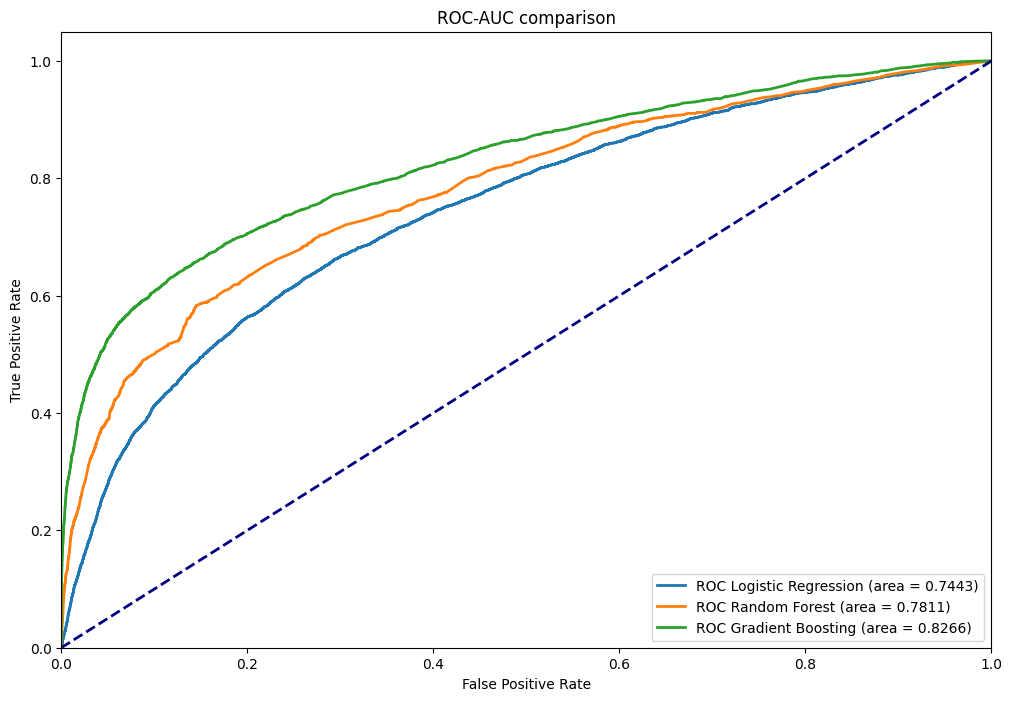

In [77]:
from numpy import sqrt
plt.figure(figsize=(12,8))

for fpr, tpr, model in [(logreg_fpr,logreg_tpr,'Logistic Regression'),(rf_fpr,rf_tpr,'Random Forest'),(gb_fpr,gb_tpr,'Gradient Boosting')]:
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=2, label='ROC '+ model + ' (area = %0.4f)' % roc_auc)
# Plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC comparison')
plt.legend(loc="lower right")
plt.show()


The graph above demonstrates that the Gradient Boosting model produces the best result across all business scenarios, realizing a smaller FPR in comparison to the same TPR of the other models. 

### Threshold For Profitability<a id='Threshold_For_Profitability'></a>


In [82]:
#Load the cleaned dataset with 'duration' column
bank_cleaned = pd.read_csv('../data/bank_cleaned2.csv', index_col=0)

#### Obtain Revenue Per Subscription<a id='Obtain_Revenue_Per_Subscription'></a>

In [80]:
#To make it more accurate, I only used the bank data that happened within one year. 
previous_year_bank = bank_cleaned[bank_cleaned.pdays> 365]
one_year_bank = bank_cleaned.drop(previous_year_bank.index)
one_year_bank.head()

,age,job,marital,education,credits,balance,housing,loan,contact_type,day,...,campaign,pdays,previous,poutcome,subscription,month_num,balance_group,campaign_contact_number,pdays_group,age_group
0,95,retired,married,secondary,no,0,no,no,telephone,1,...,1,-1,0,2,0,10,no_balance,NaN,NaN,>60
1,95,retired,divorced,primary,no,2282,no,no,telephone,21,...,17,-1,0,2,1,4,high_balance,>6,NaN,>60
2,94,retired,divorced,secondary,no,1234,no,no,cellular,3,...,1,-1,0,2,0,3,average_balance,NaN,NaN,>60
3,93,retired,married,unknown,no,775,no,no,cellular,4,...,2,13,9,1,1,8,average_balance,1,1-4months,>60
4,93,retired,married,unknown,no,775,no,no,cellular,22,...,2,177,7,1,1,7,average_balance,1,4-7months,>60


The long term average interest rate is of 4.10% and bank lending Rate in Portugal averaged 4.96%.The difference between the long-term average interest rate and lending rate is (.86%).

***
(Source:https://ycharts.com/indicators/portugal_long_term_interest_rates
https://tradingeconomics.com/portugal/bank-lending-rate)
***

In [97]:
#I multiplied the difference between the long-term average interest rate and lending rate (.86%) and the mean balance from the subscribers. 

revenue_per_subs = 0.0086 * one_year_bank[one_year_bank['subscription']==1]['balance'].mean()
revenue_per_subs

15.5944975102921

#### Calculate Cost Per Subscription<a id='Calculate_Cost_Per_Subscription'></a>

In [85]:
#Turn duration seconds to minutes
bank_cleaned['duration'] = bank_cleaned['duration'].apply(lambda n:n/60).round(2)
bank_cleaned['duration'].head()

0    0.06
1    0.06
2    0.06
3    0.13
4    0.24
Name: duration, dtype: float64

In [86]:
#Calcuate the call duration for each month
one_month_duration = one_year_bank.groupby('month_num')['duration'].sum()
one_month_duration.head()

month_num
1     6247.49
2    10873.46
3     1916.86
4    14445.30
5    58627.83
Name: duration, dtype: float64

In [87]:
#Find out the median call duration per month to figure out which call center
#plan fits the needs
one_month_duration.describe()

count       12.000000
mean     15983.408333
std      16515.615759
min       1154.930000
25%       3205.457500
50%      12659.380000
75%      22082.270000
max      58627.830000
Name: duration, dtype: float64

To calculate the cost, I found different call center pricing packages on the website www.sascallcenter.com.The bank's median call duration within one year is above 10,000 minutes, so that we can use the package of $0.89/min. 

In [88]:
#Calculate the cost per call
cost_per_call = 0.89 * one_year_bank['duration'].median()
cost_per_call 

2.67

#### Calculate Profitability Vs. Threshold <a id='Calculate_Profitability_Threshold'></a>

In [89]:
#Create profitability function
def Profitability(ylabel, pred_proba, thresholds):

    pred_proba = pred_proba >= thresholds
    matrix = confusion_matrix(ylabel, pred_proba)
   
    tn = matrix[0,0]
    tp = matrix[1,1]
    fp = matrix[0,1]
    fn = matrix[1,0]
 
    Revenue = tp * revenue_per_subs
    Cost = cost_per_call* (tp + fp)
    profit = Revenue - Cost
    
    return([Revenue, Cost, profit])

#Create a dataframe 'Profitability Vs. threshold'
threshold_df = pd.DataFrame(columns=['Revenue','Cost','profit'])
y_pred_proba = GBModel_10.best_estimator_.predict_proba(X_GB_10)[:,1] 
for threshold in np.arange(0, 1, 0.01):
    threshold_df.loc[threshold] = Profitability(ylr, y_pred_proba, threshold)
    
#Find out the best threshild for maximum profitability    
best_thresh = threshold_df[threshold_df['profit'] == threshold_df['profit'].max()].index[0]


In [91]:
best_thresh

0.18

Text(0.16, 0.57, 'Optimal Threshold 0.18')

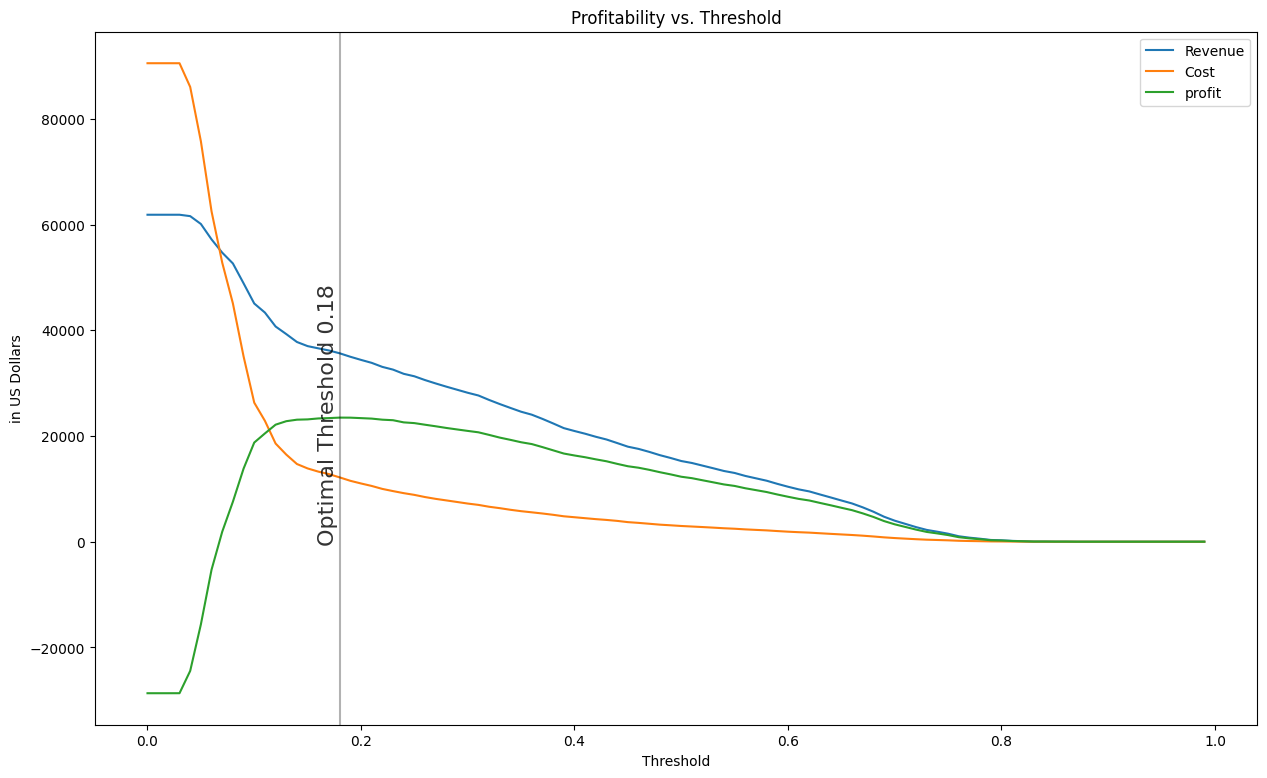

In [94]:
#Plot Profitability vs. Threshold
ax = threshold_df.plot(y=['Revenue', 'Cost', 'profit'],figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_ylabel('in US Dollars')
ax.set_title('Profitability vs. Threshold')
ax.axvline(best_thresh, color='black', alpha=0.3)
ax.text(0.16,.57,'Optimal Threshold 0.18',rotation=90, alpha=0.8, fontsize=16)


In [95]:
#Calculate the maximum profit
threshold_df.loc[0.18]

Revenue    35649.021309
Cost       12169.860000
profit     23479.161309
Name: 0.18, dtype: float64

In [96]:
#Bank only needs to call 13% of the customers to reach the maximum profit
(y_pred_proba >=.18).mean()

0.13442651959772317

The optimal threshold is 0.18. It has an AUC value of 0.826 in distinguishing between the positive and negative classes. Since the dataset is highly imbalanced, I used the predict_probability >= threshold in the classification report and confusion matrix to handle the imbalanced data.

### Test Data<a id='Test_Data'></a>

#### Calcuate ROC AUC Score <a id='Calcuate_ROC_AUC_Score'></a>

In [101]:
X_test = Xtest[gb_feature_10]
GBModel_10.score(X_test,ytest)

0.78479602924831

The test set has a lower Roc score at 0.785 instead of 0.826 with the training set. 

#### Classification Report <a id='Classification_Report'></a>

In [103]:
ytest_pred_proba = GBModel_10.best_estimator_.predict_proba(X_test)[:,1] 
print(classification_report(ytest,ytest_pred_proba>=0.18))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      9981
           1       0.45      0.51      0.48      1322

    accuracy                           0.87     11303
   macro avg       0.69      0.71      0.70     11303
weighted avg       0.88      0.87      0.87     11303



If the bank called customers based on the model prediction results, it would increase the conversion rates from 12% to 45%. In other words, without using the model, 1 out of 8 clients (class 1 percent of the whole dataset is 0.117 ) will subscribe, whereas now,  one out of every two to three clients will do so. (precision score for class1 is 0.45)


#### Confusion Matrix<a id='Confusion_Matrix'></a>

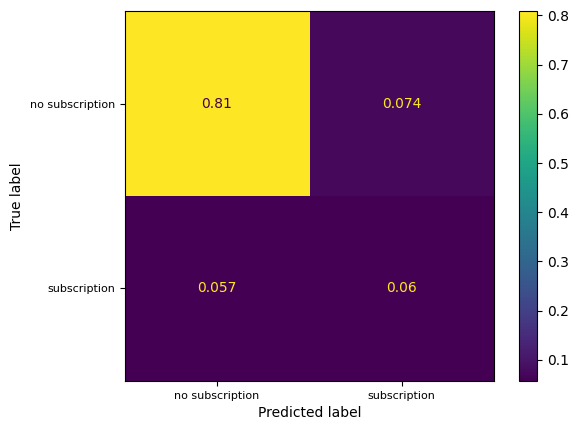

In [104]:
cm_rf_test = confusion_matrix(ytest, ytest_pred_proba>=0.18)
percent_cm_rf_test = cm_rf_test/cm_rf_test.sum()
_, ax = plt.subplots()
display_percent_cm_rf_test = ConfusionMatrixDisplay(confusion_matrix = percent_cm_rf_test, 
                                    display_labels = ['no subscription', 'subscription'])

ax.set_xticklabels(labels = ['no subscription', 'subscription'], fontsize = 8)
ax.set_yticklabels(labels = ['no subscription', 'subscription'], fontsize = 8)
display_percent_cm_rf_test.plot(ax = ax)

### Modeling Scenarios<a id='Modeling_Scenarios'></a>

#### GB Model<a id='GB_Model'></a> 

Bank calls customers according to the GB model predictions.

In [113]:
#What's the percentage of the customers the bank needs to call?
(ytest_pred_proba >=.18).mean()

0.1340352118906485

In [115]:
#Calculate the revune, cost and profit
Revenue, Cost, profit = Profitability(ytest, ytest_pred_proba, 0.18)
profit

6481.235819447169

#### Scenario 1<a id='Scenario_1'></a> 

Bank calls customers in the age group of >60 and < 30.


In [105]:
age_group = Xtest['age_group_>60'] + Xtest['age_group_<30']
age_group

6023     0
18268    0
41176    1
22430    0
17321    0
        ..
961      1
28223    0
11107    0
32384    0
43689    1
Length: 11303, dtype: uint8

In [106]:
#What's the percentage of the customers the bank needs to call?
len(age_group[age_group ==1])/len(Xtest)

0.17756347872246306

In [108]:
#Check tp and fp if bank called customers in the age group of >60 and < 30.
matrix_age_group = confusion_matrix(ytest, age_group)
tp_age_group = matrix_age_group[1,1]
fp_age_group = matrix_age_group[0,1]

#Calculate the revune, cost and profit
Revenue_age_group = tp_age_group * revenue_per_subs
Cost_age_group = cost_per_call* (tp_age_group + fp_age_group)
profit_age_group = Revenue_age_group - Cost_age_group
profit_age_group

910.297999137425

#### Scenario 2 <a id='Scenario_2'></a> 

Bank calls customers with tertiary education.

In [109]:
education_tertiary = Xtest['education_tertiary']
education_tertiary

6023     1
18268    0
41176    1
22430    0
17321    1
        ..
961      0
28223    0
11107    0
32384    1
43689    0
Name: education_tertiary, Length: 11303, dtype: uint8

In [110]:
#What's the percentage of the customers the bank needs to call?
len(education_tertiary[education_tertiary ==1])/len(Xtest)

0.2923117756347872

In [111]:
#Check tp and fp if bank called customers in the age group of >60 and < 30.

y_pred_n_tertiary = Xtest['education_tertiary'] == 1
matrix_n_tertiary = confusion_matrix(ytest, y_pred_n_tertiary)

tp_n_tertiary = matrix_n_tertiary[1,1]
fp_n_tertiary = matrix_n_tertiary[0,1]

#Calculate the revune, cost and profit
Revenue_n_tertiary = tp_n_tertiary * revenue_per_subs
Cost_n_tertiary = cost_per_call* (tp_n_tertiary + fp_n_tertiary)
profit_n_tertiary = Revenue_n_tertiary - Cost_n_tertiary

profit_n_tertiary

-1211.565214977455

#### Scenario 3<a id='Scenario_3'></a> 

Bank calls all the customers.

In [112]:
#Calculate the revune, cost and profit
bank_revenue_all = revenue_per_subs * len(ytest[ytest ==1].index)
profit_call_all = bank_revenue_all - cost_per_call * len(ytest.index)
profit_call_all

-9563.084291393843

### Plot and Summary<a id='Plot_and_Summary'></a> 

In [116]:
data = {'% customers to call': [0.13,0.17,0.29,1],
        'profit': [6481,910,-1211,-9563]}
 
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['GB Model',
                               'Scenario 1',
                               'Scenario 2',
                               'Scenario 3'])
df

,% customers to call,profit
GB Model,0.13,6481
Scenario 1,0.17,910
Scenario 2,0.29,-1211
Scenario 3,1.00,-9563


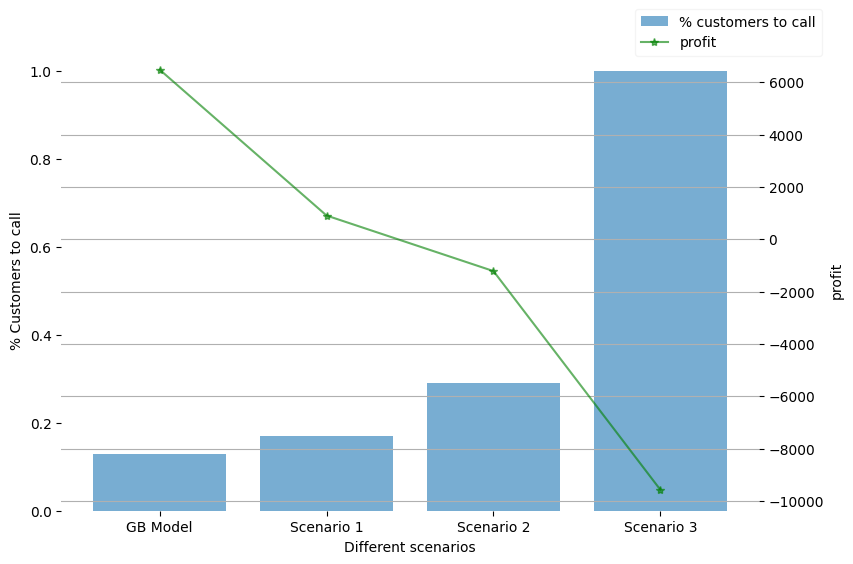

In [122]:
#Plot the dataframe to compare the ratio of client calls and the yielding profit 
fig, ax = plt.subplots()

fig.set_size_inches(9,6)
fontsize = 15

ax.bar(df.index, df['% customers to call'],
                    alpha=0.6)

ax.set_ylabel('% Customers to call')
ax.set_xlabel('Different scenarios')

        
ax2 = plt.twinx()
ax2.plot(df.index, df['profit'], marker='*', color= 'green',alpha=0.6)
#line = ax.lines[0]
ax2.set_ylabel('profit')
#ax2.grid(False)
        
        
fig.legend(labels=('% customers to call','profit'),loc='upper right',bbox_to_anchor=(1.1,1.1),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.2)
sns.despine(left=True,bottom=True,)
plt.grid(axis = 'y')
plt.show();


How might this model be helpful? In order to determine the answer to this question, I developed three different strategies that the bank might use to determine which customers to call to compare to the strategy of using the output of the Gradient Boosting model I developed. 

Then, I calculated the profitability of each of these scenarios (as well as the % of customer calls needed) and displayed the results in the chart above.

As we can see, scenarios 2 and 3 are actually losing money with a negative profit, while scenario 1 has a profit of 900. However, the GB model skyrockets the profit to $6481, a 600% increase over the only other profitable strategy. 

From a customer conversion perspective, we can see that using the model would increase the conversion rates from 12% to 45%. In other words, without using the model, 1 out of 8 clients (class 1 percent of the whole dataset is 0.117 ) will subscribe, whereas now, one out of every two to three clients will do so. (precision score for class1 is 0.45)

### Future Work<a id='Future_Work'></a> 

For future work, increasing the size of the training set, especially across multiple years, would be recommended, as well as including various demographic information such as race, ethnicity, gender, and location. 